In [1]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))
# Creat class for buffer memory 

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [3]:
class DQN(nn.Module):

    def __init__(self, hidden_size, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, hidden_size)
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.layer3 = nn.Linear(hidden_size, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [14]:
env = gym.make("LunarLander-v3") # set our environment

In [ ]:
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4
FULL_MEMORY_LENGTH = 10000
hidden_size = 256



# Получить число действий
n_actions = env.action_space.n
# Получить число степеней свободы состояний
state, info = env.reset()
n_observations = len(state)

# Инициилизировать сети: целевую и политики
policy_net = DQN(hidden_size, n_observations, n_actions).to(device)
target_net = DQN(hidden_size, n_observations, n_actions).to(device)

# Подгрузить в целевую сеть коэффициенты из сети политики
target_net.load_state_dict(policy_net.state_dict())

# Задать оптимайзер
optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)

# Инициализировать Replay Memory buffer
memory = ReplayMemory(FULL_MEMORY_LENGTH)


steps_done = 0

#массив длительности эпизода - пойдет в отчет о том, сколько продержался агент
episode_durations = []

In [22]:
# еpsilon-жадная стратегия выбора действия
def select_action(state):
    global steps_done  # глобальный шаги для убывания epsilon
#     случайное значение для определения какой шаг будем делать жадный или случайный
    sample = random.random()
    
#     установка порога принятия решения - уровня epsilon
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    
#     увеличиваем счетчик шагов
    steps_done += 1
    
#     если случайный порог больше epsilon-порога
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) вернет наибольшее значение столбца в каждой строке.
            # Второй столбец в результате max - это индекс того места, 
            # где был найден максимальный элемент, 
            # поэтому мы выбираем действие с наибольшим ожидаемым вознаграждением.
            return policy_net(state).max(1)[1].view(1, 1) # choose max probable value logit
    else:
        # Иначы выбираем случайное дайствие
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

In [33]:
def optimize_model(batch_size: int):
    if len(memory) < batch_size:
        return
    
    # Получить из памяти батч
    transitions = memory.sample(batch_size)
    # Преобразовать его в namedtuple
    batch = Transition(*zip(*transitions))

    # Вычислить маску нефинальных состояний и соединить элементы батча
    # (финальным состоянием должно быть то, после которого моделирование закончилось)

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                        batch.next_state)), device=device, dtype=torch.bool)
    
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    
    # Собираем батчи для состояний, действий и наград
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Вычислить Q(s_t, a) - модель вычисляет Q(s_t), 
    # затем мы выбираем столбцы предпринятых действий. 
    # Это те действия, которые были бы предприняты для каждого состояния партии в соответствии с policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Вычислить V(s_{t+1}) для всех следующих состояний.
    # Ожидаемые значения действий для не_финальных_следующих_состояний вычисляются 
    # на основе "старшей" целевой_сети; выбирается их наилучшее вознаграждение с помощью max(1)[0].
    # Это объединяется по маске, так что мы будем иметь либо ожидаемое значение состояния, 
    # либо 0, если состояние было финальным.
    next_state_values = torch.zeros(batch_size, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    # Вычисляем ожидаемые Q значения
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Объединяем все в общий лосс
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Готовим градиент
    optimizer.zero_grad()
    loss.backward()
    # Обрезаем значения градиента - проблемма исчезающего/взрывающего градиента
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    
    optimizer.step()

In [35]:
'''
if torch.cuda.is_available():
    num_episodes = 1500
else:
    num_episodes = 500
'''
num_episodes = 1000
total_reward = []

for i_episode in tqdm(range(num_episodes)):
    episode_reward = 0
    # Для каждого эпизода инициализируем начальное состояние
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    
    # выполняем действия пока не получим флаг done
    # t - считает сколько шагов успели сделать пока шест не упал
    for t in count():
        # выбираем действие [0, 1]
        action = select_action(state)
        # Делаем шаг
        observation, reward, terminated, truncated, _ = env.step(action.item())
        episode_reward += reward

        # Преобразуем в тензор
        reward = torch.tensor([reward], device=device)
        
        # Объединяем done по двум конечным состояниям
        done = terminated or truncated
        
        # присваиваем следующее состояние
        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # отправляем в память
        memory.push(state, action, next_state, reward)

        # переходим на следующее состояние
        state = next_state

        # запускаем обучение сети
        optimize_model(batch_size=128)

        # делаем "мягкое" обновление весов
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)
        
        # Если получили terminated or truncated завершаем эпизод обучения
        if done:
            # добавляем в массив продолжительность эпизода
            episode_durations.append(t + 1)
            total_reward.append(episode_reward)
            break

print('Complete')

100%|██████████| 1000/1000 [15:21<00:00,  1.09it/s]

Complete


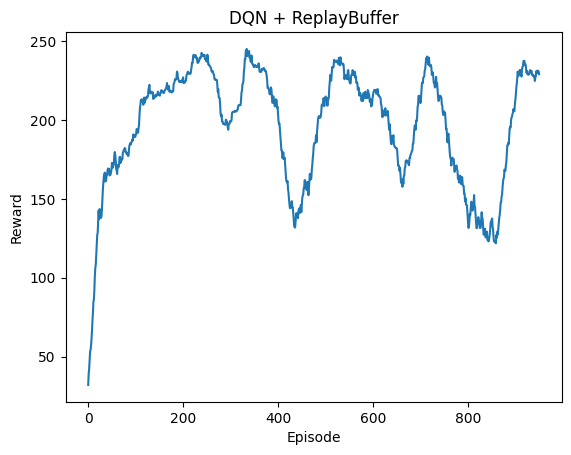

In [36]:
# Вычисление скользящего среднего
window_size = 50
moving_avg = np.convolve(total_reward, np.ones(window_size)/window_size, mode='valid')
plt.plot(moving_avg)
plt.title('DQN + ReplayBuffer')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

## Optuna hyperparameters optimization

In [42]:
import optuna
def objective(trial):
    # Оптимизируемые параметры
    LR = trial.suggest_float('LR', 1e-5, 1e-3, log = True)
    hidden_size = trial.suggest_int('hidden_size', 128, 512)

    # Параметры RL
    TAU = 0.005
    FULL_MEMORY_LENGTH = 10000

    # Инициализация среды
    env = gym.make("LunarLander-v3")
    n_actions = env.action_space.n
    state, info = env.reset()
    n_observations = len(state)

    # Инициализация сетей
    policy_net = DQN(hidden_size, n_observations, n_actions).to(device)
    target_net = DQN(hidden_size, n_observations, n_actions).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=LR)
    memory = ReplayMemory(FULL_MEMORY_LENGTH)

    num_episodes = 300
    total_reward = []

    for i_episode in range(num_episodes):
        state, info = env.reset()
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        episode_reward = 0

        for t in count():
            
            action = select_action(state)
            # Делаем шаг
            observation, reward, terminated, truncated, _ = env.step(action.item())
            episode_reward += reward

            # Преобразуем в тензор
            reward = torch.tensor([reward], device=device)
            
            # Объединяем done по двум конечным состояниям
            done = terminated or truncated
            
            # присваиваем следующее состояние
            if terminated:
                next_state = None
            else:
                next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

            # отправляем в память
            memory.push(state, action, next_state, reward)

            # переходим на следующее состояние
            state = next_state

            # запускаем обучение сети
            optimize_model(batch_size=128)

            # делаем "мягкое" обновление весов
            # θ′ ← τ θ + (1 −τ )θ′
            target_net_state_dict = target_net.state_dict()
            policy_net_state_dict = policy_net.state_dict()
            
            for key in policy_net_state_dict:
                target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
            target_net.load_state_dict(target_net_state_dict)
            
            # Если получили terminated or truncated завершаем эпизод обучения
            if done:
                # добавляем в массив продолжительность эпизода
                episode_durations.append(t + 1)
                total_reward.append(episode_reward)
                break
    
    avg_reward = sum(total_reward[-50:]) / 50  # Средняя награда за последние 50 эпизодов
    return avg_reward



In [43]:
# Оптимизация с помощью Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
print('Best hyperparameters:', study.best_params)
print('Best average reward:', study.best_value)

[I 2025-02-04 09:09:16,638] A new study created in memory with name: no-name-5863bc1c-33f7-446d-a40c-f609b1a8e5e8
[I 2025-02-04 09:14:20,725] Trial 0 finished with value: 213.14067586809676 and parameters: {'LR': 3.8817589442534175e-05, 'hidden_size': 186}. Best is trial 0 with value: 213.14067586809676.
[I 2025-02-04 09:19:06,070] Trial 1 finished with value: 192.19933929597937 and parameters: {'LR': 0.0006223628029382671, 'hidden_size': 451}. Best is trial 0 with value: 213.14067586809676.
[I 2025-02-04 09:23:21,290] Trial 2 finished with value: 163.7853716525689 and parameters: {'LR': 0.00038239341712756824, 'hidden_size': 368}. Best is trial 0 with value: 213.14067586809676.
[I 2025-02-04 09:27:50,688] Trial 3 finished with value: 197.6842906615596 and parameters: {'LR': 7.967906081973115e-05, 'hidden_size': 226}. Best is trial 0 with value: 213.14067586809676.
[I 2025-02-04 09:31:47,552] Trial 4 finished with value: 183.5037686945244 and parameters: {'LR': 0.00026703569228570976, 

Best hyperparameters: {'LR': 3.8817589442534175e-05, 'hidden_size': 186}
Best average reward: 213.14067586809676


In [ ]:
# Optimization does not work
# Thinking it could be connected with reward period and atability of alghoritms

In [44]:
best_params = study.best_params
print("Лучшие параметры:", best_params)

Лучшие параметры: {'LR': 3.8817589442534175e-05, 'hidden_size': 186}


In [49]:
best_lr = best_params['LR']
best_hidden_size = best_params['hidden_size']

# Создаём новую модель с лучшими параметрами
policy_net = DQN(best_hidden_size, n_observations, n_actions).to(device)
target_net = DQN(best_hidden_size, n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

# Оптимизатор с лучшим lr
optimizer = optim.AdamW(policy_net.parameters(), lr=best_lr, amsgrad=True)
total_reward = []
# Проводим финальное обучение
for i_episode in tqdm(range(num_episodes)):
    episode_reward = 0
    # Для каждого эпизода инициализируем начальное состояние
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    
    # выполняем действия пока не получим флаг done
    # t - считает сколько шагов успели сделать пока шест не упал
    for t in count():
        # выбираем действие [0, 1]
        action = select_action(state)
        # Делаем шаг
        observation, reward, terminated, truncated, _ = env.step(action.item())
        episode_reward += reward

        # Преобразуем в тензор
        reward = torch.tensor([reward], device=device)
        
        # Объединяем done по двум конечным состояниям
        done = terminated or truncated
        
        # присваиваем следующее состояние
        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # отправляем в память
        memory.push(state, action, next_state, reward)

        # переходим на следующее состояние
        state = next_state

        # запускаем обучение сети
        optimize_model(batch_size=128)

        # делаем "мягкое" обновление весов
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)
        
        # Если получили terminated or truncated завершаем эпизод обучения
        if done:
            # добавляем в массив продолжительность эпизода
            episode_durations.append(t + 1)
            total_reward.append(episode_reward)
            break

print('Complete')

# Сохраняем обученную модель
torch.save(policy_net.state_dict(), "best_dqn_model.pth")
print("Модель сохранена как 'best_dqn_model.pth'")

100%|██████████| 1000/1000 [24:02<00:00,  1.44s/it]

Complete
Модель сохранена как 'best_dqn_model.pth'


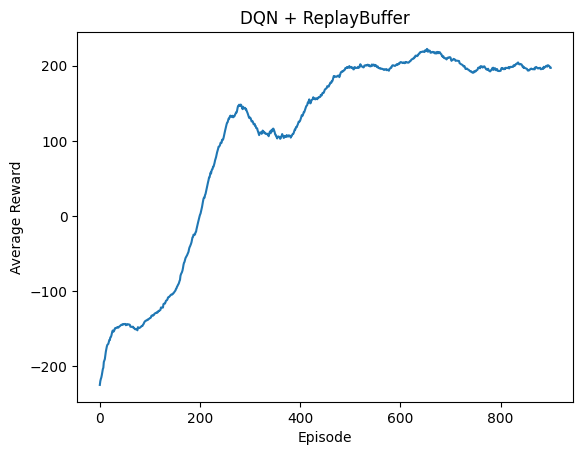

<Figure size 640x480 with 0 Axes>

In [57]:
# Вычисление скользящего среднего
window_size = 100
moving_avg = np.convolve(total_reward, np.ones(window_size)/window_size, mode='valid')
plt.plot(moving_avg)
plt.title('DQN + ReplayBuffer')
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.show()
plt.savefig("Average reward graph")

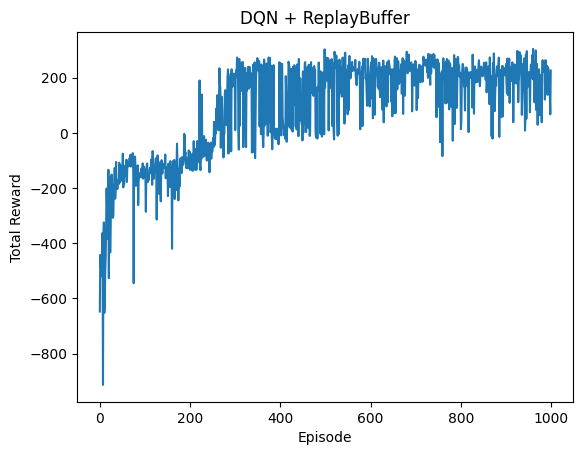

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.plot(total_reward)
plt.title('DQN + ReplayBuffer')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.savefig("reward graph total")
plt.show()


In [56]:
# В целом вышло на плато обучение.  Но обучение сильно не стабильно что видно из первого запуска и неудачной оптимизации

In [51]:
# Загрузка модели
policy_net = DQN(best_hidden_size, n_observations, n_actions).to(device)
policy_net.load_state_dict(torch.load("best_dqn_model.pth"))
policy_net.eval()  # Переводим модель в режим инференса

DQN(
  (layer1): Linear(in_features=8, out_features=186, bias=True)
  (layer2): Linear(in_features=186, out_features=186, bias=True)
  (layer3): Linear(in_features=186, out_features=4, bias=True)
)